Sebastian Raschka, 2015  
`mlxtend`, a library of extension and helper modules for Python's data analysis and machine learning libraries

- GitHub repository: https://github.com/rasbt/mlxtend
- Documentation: http://rasbt.github.io/mlxtend/

View this page in [jupyter nbviewer](http://nbviewer.ipython.org/github/rasbt/mlxtend/blob/master/docs/sources/_ipynb_templates/regressor/linear_regression.ipynb)

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -u -d -v -p matplotlib,numpy,scipy,mlxtend

Sebastian Raschka 
last updated: 2016-03-05 

CPython 3.5.1
IPython 4.0.3

matplotlib 1.5.1
numpy 1.10.4
scipy 0.17.0
mlxtend 0.3.1.dev0


In [2]:
%matplotlib inline

# StackingClassifier

An ensemble-learning meta-classifier for stacking.

> from mlxtend.classifier import StackingClassifier

# Overview

Stacking is an ensemble learning technique to combine multiple classification models via a meta-classifier. The individual classification models are trained based on the complete training set; then, the meta-classifier is fitted based on the outputs -- meta-features -- of the individual classification models in the ensemble.
The meta-classifier can either be trained on the predicted class labels or probabilities from the ensemble.

![](./StackingClassifier_files/stackingclassification_overview.png)

The algorithm can be summarized as follows (source: [1]):
    
![](./StackingClassifier_files/stacking_algorithm.png)

### References


- [1] Tang, J., S. Alelyani, and H. Liu. "[Data Classification: Algorithms and Applications.](https://books.google.com/books?id=nwQZCwAAQBAJ&lpg=PA500&dq=stacking%20classifier%20subsets&pg=PA499#v=onepage&q&f=false)" Data Mining and Knowledge Discovery Series, CRC Press (2015): pp. 498-500.
- [2] Wolpert, David H. "[Stacked generalization.](http://www.sciencedirect.com/science/article/pii/S0893608005800231)" Neural networks 5.2 (1992): 241-259.

# Examples

In [3]:
# Stacking classifier

# Sebastian Raschka 2014-2016
# mlxtend Machine Learning Library Extensions
#
# An ensemble-learning meta-classifier for stacking
# Author: Sebastian Raschka <sebastianraschka.com>
#
# License: BSD 3 clause

from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.base import TransformerMixin
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np


class StackingClassifier(BaseEstimator, ClassifierMixin, TransformerMixin):
    """A Stacking classifier for scikit-learn estimators for classification.
    
    Parameters
    ----------
    classifiers : array-like, shape = [n_regressors]
        A list of classifiers.
        Invoking the `fit` method on the `StackingClassifer` will fit clones
        of these original classifiers that will
        be stored in the class attribute
        `self.clfs_`.
    meta_classifier : object
        The meta-classifier to be fitted on the ensemble of
        classifiers
    use_probas : bool (default: False)
        If True, trains meta-classifier based on predicted probabilities
        instead of class labels.
    verbose : int, optional (default=0)
        Controls the verbosity of the building process.
        - `verbose=0` (default): Prints nothing
        - `verbose=1`: Prints the number & name of the regressor being fitted
        - `verbose=2`: Prints info about the parameters of the
                       regressor being fitted
        - `verbose>2`: Changes `verbose` param of the underlying regressor to
           self.verbose - 2
           
    Attributes
    ----------
    clfs_ : list, shape=[n_classifiers]
        Fitted classifiers (clones of the original classifiers)
    meta_clf_ : estimator
        Fitted meta-classifier (clone of the original meta-estimator)
        
    """
    def __init__(self, classifiers, meta_classifier, use_probas=False, verbose=0):

        self.classifiers = classifiers
        self.meta_classifier = meta_classifier
        self.named_classifiers = {key: value for
                                  key, value in
                                  _name_estimators(classifiers)}
        self.named_meta_classifier = {'meta-%s' % key: value for
                                      key, value in
                                      _name_estimators([meta_classifier])}
        self.use_probas = use_probas
        self.verbose = verbose

    def fit(self, X, y):
        """ Fit ensemble classifers and the meta-classifier.
        
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.
        
        Returns
        -------
        self : object
        
        """
        self.clfs_ = [clone(clf) for clf in self.classifiers]
        self.meta_clf_ = clone(self.meta_classifier)
        if self.verbose > 0:
            print("Fitting %d classifiers..." % (len(self.classifiers)))

        for clf in self.clfs_:

            if self.verbose > 0:
                i = self.clfs_.index(clf) + 1
                print("Fitting classifier%d: %s (%d/%d)" %
                      (i, _name_estimators((clf,))[0][0], i, len(self.clf_)))

            if self.verbose > 2:
                if hasattr(clf, 'verbose'):
                    clf.set_params(verbose=self.verbose - 2)

            if self.verbose > 1:
                print(_name_estimators((clf,))[0][1])

            clf.fit(X, y)

        meta_features = self._predict_meta_features(X)
        self.meta_clf_.fit(meta_features, y)
        return self
    
    def get_params(self, deep=True):
        """Return estimator parameter names for GridSearch support."""
        if not deep:
            return super(StackingClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value

            out.update(self.named_meta_classifier.copy())
            for name, step in six.iteritems(self.named_meta_classifier):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

    def _predict_meta_features(self, X):
        if self.use_probas:
            probas = np.asarray([clf.predict_proba(X) for clf in self.clfs_])
            vals = np.average(probas, axis=0)
        else:
            vals = np.asarray([clf.predict(X) for clf in self.clfs_]).T
        return vals

    def predict(self, X):
        """ Predict target values for X.
        
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        
        Returns
        ----------
        labels : array-like, shape = [n_samples]
            Predicted class labels.
            
        """
        meta_features = self._predict_meta_features(X)
        return self.meta_clf_.predict(meta_features)
    
    def predict_proba(self, X):
        """ Predict class probabilities for X.
       
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        
        Returns
        ----------
        proba : array-like, shape = [n_samples, n_classes]
            Probability for each class per sample.
        
        """
        meta_features = self._predict_meta_features(X)
        return self.meta_clf_.predict_proba(meta_features)

## Example 1 - Simple Stacked Classification

In [4]:
from sklearn import datasets

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

In [5]:
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
import numpy as np

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = cross_validation.cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.91 (+/- 0.06) [Random Forest]
Accuracy: 0.92 (+/- 0.03) [Naive Bayes]
Accuracy: 0.95 (+/- 0.03) [StackingClassifier]


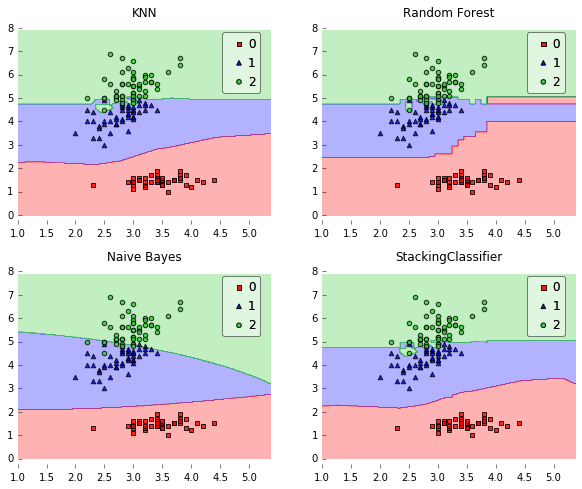

In [6]:
import matplotlib.pyplot as plt
from mlxtend.evaluate import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10,8))

for clf, lab, grd in zip([clf1, clf2, clf3, sclf], 
                         ['KNN', 
                          'Random Forest', 
                          'Naive Bayes',
                          'StackingClassifier'],
                          itertools.product([0, 1], repeat=2)):

    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(lab)

## Example 2 - Stacked Classification and GridSearch

To set up a parameter grid for scikit-learn's `GridSearch`, we simply provide the estimator's names in the parameter grid -- in the special case of the meta-regressor, we append the `'meta-'` prefix.

In [7]:
from sklearn.grid_search import GridSearchCV

# Initializing models

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

params = {'kneighborsclassifier__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta-logisticregression__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(X, y)

for params, mean_score, scores in grid.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
        % (mean_score, scores.std() / 2, params))

0.667 (+/-0.000) for {'kneighborsclassifier__n_neighbors': 1, 'randomforestclassifier__n_estimators': 10, 'meta-logisticregression__C': 0.1}
0.667 (+/-0.000) for {'kneighborsclassifier__n_neighbors': 1, 'randomforestclassifier__n_estimators': 50, 'meta-logisticregression__C': 0.1}
0.927 (+/-0.022) for {'kneighborsclassifier__n_neighbors': 1, 'randomforestclassifier__n_estimators': 10, 'meta-logisticregression__C': 10.0}
0.913 (+/-0.027) for {'kneighborsclassifier__n_neighbors': 1, 'randomforestclassifier__n_estimators': 50, 'meta-logisticregression__C': 10.0}
0.667 (+/-0.000) for {'kneighborsclassifier__n_neighbors': 5, 'randomforestclassifier__n_estimators': 10, 'meta-logisticregression__C': 0.1}
0.667 (+/-0.000) for {'kneighborsclassifier__n_neighbors': 5, 'randomforestclassifier__n_estimators': 50, 'meta-logisticregression__C': 0.1}
0.933 (+/-0.024) for {'kneighborsclassifier__n_neighbors': 5, 'randomforestclassifier__n_estimators': 10, 'meta-logisticregression__C': 10.0}
0.940 (+/-

In case we are planning to use a regression algorithm multiple times, all we need to do is to add an additional number suffix in the parameter grid as shown below:

In [8]:
from sklearn.grid_search import GridSearchCV

# Initializing models

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf1, clf2, clf3], 
                          meta_classifier=lr)

params = {'kneighborsclassifier-1__n_neighbors': [1, 5],
          'kneighborsclassifier-2__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta-logisticregression__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(X, y)

for params, mean_score, scores in grid.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
        % (mean_score, scores.std() / 2, params))

0.667 (+/-0.000) for {'randomforestclassifier__n_estimators': 10, 'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta-logisticregression__C': 0.1}
0.667 (+/-0.000) for {'randomforestclassifier__n_estimators': 50, 'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta-logisticregression__C': 0.1}
0.907 (+/-0.029) for {'randomforestclassifier__n_estimators': 10, 'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta-logisticregression__C': 10.0}
0.913 (+/-0.027) for {'randomforestclassifier__n_estimators': 50, 'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta-logisticregression__C': 10.0}
0.667 (+/-0.000) for {'randomforestclassifier__n_estimators': 10, 'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 5, 'meta-logisticregression__C': 0.1}
0.667 (+/-0.000) for {'randomforestclassifier__n_estimators': 50, 'kneigh

# API

In [10]:
with open('../../api_modules/mlxtend.classifier/StackingClassifier.md', 'r') as f:
    print(f.read())

## StackingClassifier

*StackingClassifier(classifiers, meta_classifier, use_probas=False, verbose=0)*

A Stacking classifier for scikit-learn estimators for classification.

**Parameters**

- `classifiers` : array-like, shape = [n_regressors]

    A list of classifiers.
    Invoking the `fit` method on the `StackingClassifer` will fit clones
    of these original classifiers that will
    be stored in the class attribute
    `self.clfs_`.

- `meta_classifier` : object

    The meta-classifier to be fitted on the ensemble of
    classifiers

- `use_probas` : bool (default: False)

    If True, trains meta-classifier based on predicted probabilities
    instead of class labels.

- `verbose` : int, optional (default=0)

    Controls the verbosity of the building process.
    - `verbose=0` (default): Prints nothing
    - `verbose=1`: Prints the number & name of the regressor being fitted
    - `verbose=2`: Prints info about the parameters of the
    regressor being fitted
    - `verbose>2